In [1]:
import dirfile_functions as df
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import Ian_functions as load
import pandas as pd
from scipy import signal
roach_path = 'roach_data/'
ancillary_path = 'xy_stage/'
old_path = '2012_data/'
bolo_path = '2012_data/bolo_data/'

In [2]:
reload(load);

In [3]:
#stolen from stack overflow to test
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [4]:
#%matplotlib notebook

In [5]:
#loads the data in, third argument is the file type u16 is uint16 u32 is uint32 and s32 is signed int32
ra = load.loadArbData(old_path, 'ra', 'u32')
dec = load.loadArbData(old_path, 'dec', 's32')
bolo = load.loadArbData(bolo_path, 'n22c06', 'u32')

In [6]:
max(ra), max (dec), max(bolo)

(4294964038, 221628191, 10769312)

In [7]:
np.mean(ra), np.mean(dec), len(bolo)

(1743466778.6913707, -473535326.3341219, 117491800)

In [8]:
# linear combination values to convert RA, DEC, and BOLO data to useful numbers from their dirfile values
# RA               LINCOM 1 ra               5.587935447693e-09 0.000000000000e+00
# DEC              LINCOM 1 dec              8.381903171539e-08 0.000000000000e+00
# N29C05           LINCOM 1 n29c05           6.903363270000e-07 -5.787153550000e+00

In [9]:
ra_a =  5.587935447693e-09
ra_b = 0
dec_a = 8.381903171539e-08
dec_b = 0
bolo_a = 6.903363270000e-07
bolo_b = -5.787153550000e+00

In [10]:
# conversion from dirfiles to useful data
bolo = bolo_a*bolo + bolo_b
ra = ra*ra_a
dec = dec*dec_a

In [11]:
# sanity check
max(bolo), max(ra), max(dec)

(1.647293740397024, 23.999981794506866, 18.57666037045351)

In [12]:
# start of setting plotting ranges, probably should interpolate the data to bring ra dec to 100hz from 5hz
#bolo_start = 20*3652830
#bolo_range = 129450*20
#slow_range = 129450
#slow_start = 3652830
#arb range 8.4 days into flight, post SC failure, try new one below
# arbitrary range I created. seems to contain a scan?
#bolo_start = 20*(1603980-50000)
#bolo_range = 285000*20
#slow_range = 285000
#slow_start = 1603980-50000
#above looks to be a vela c scan, finding more
#bolo_start = 20*(269940)
#bolo_range = 29520*20
#slow_range = 29520
#slow_start = 269940
#above is probably carina nebula
bolo_start = 20*(269940)
bolo_range = 29520*20
slow_range = 29520
slow_start = 269940

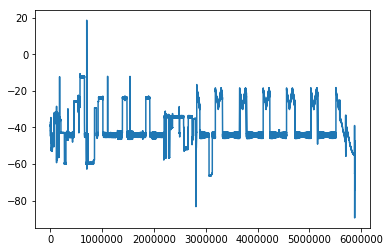

In [13]:
plt.plot(dec)

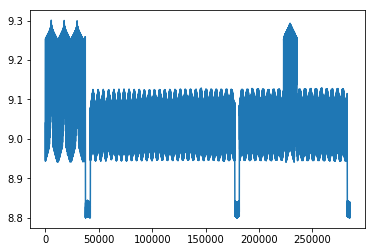

In [14]:
plt.plot(ra[1603980-50000:1603980+235000])

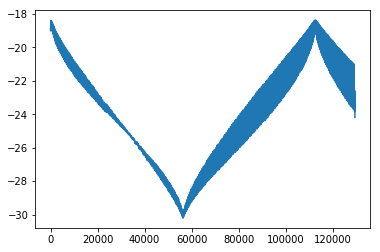

In [15]:
# more sanity check plots, make sure values are reasonable
plt.plot(dec[3652830:3652830+129450])

In [16]:
3652830./5./3600./24.

8.455625

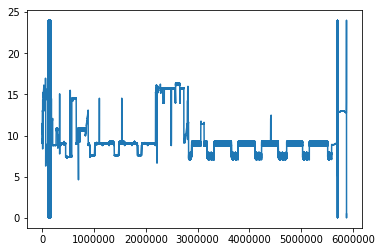

In [17]:
plt.plot(ra)

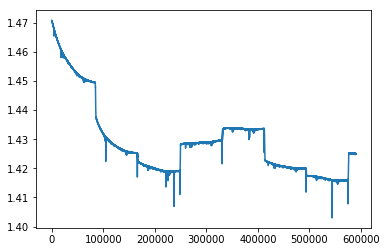

In [18]:
plt.plot(bolo[bolo_start:bolo_start+bolo_range])

In [19]:
t5 = np.arange(len(ra))/5.
t100 = np.arange(len(bolo))/100.

In [20]:
len(ra)

5874590

In [21]:
ra_int = interp1d(t5[slow_start:slow_start+slow_range+1], ra[slow_start:slow_start+slow_range+1], kind='linear')
dec_int = interp1d(t5[slow_start:slow_start+slow_range+1], dec[slow_start:slow_start+slow_range+1], kind= 'linear')

In [22]:
t100_use = t100[bolo_start+1:bolo_start+bolo_range-1]
t5_use = t5[slow_start:slow_start+slow_range]

In [23]:
print(t100_use.min())
print(t100_use.max())
print(t5_use.min())
print(t5_use.max())

53988.01
59891.98
53988.0
59891.8


In [24]:
dec_100 = dec_int(t100[bolo_start+1:bolo_start+bolo_range-1])
ra_100 = ra_int(t100[bolo_start+1:bolo_start+bolo_range-1])

In [25]:
t100[bolo_start+1], t5[slow_start]

(53988.01, 53988.0)

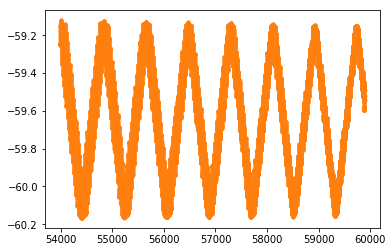

In [26]:

plt.plot(t100_use,dec_100)
plt.plot(t5[slow_start:slow_start+slow_range],dec[slow_start:slow_start+slow_range],'.')

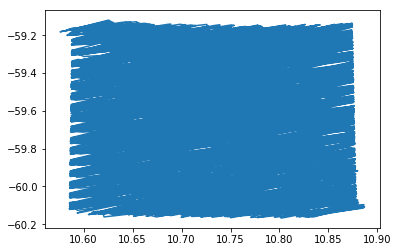

In [27]:
plt.plot(ra[slow_start:slow_start+slow_range], dec[slow_start:slow_start+slow_range])

In [28]:
np.mean(ra[slow_start:slow_start+slow_range]), np.mean(dec[slow_start:slow_start+slow_range])

(10.731404846507312, -59.637122412369024)

In [29]:
%%time
nbins = 1000
fs = 100
cutoff = 2
filt_bolo = butter_highpass_filter(bolo, cutoff, fs)
#mag_map_med = binned_statistic_2d(x_s, y_s, m, 'median',bins=nbins)
mag_map = binned_statistic_2d(ra_100, dec_100, filt_bolo[bolo_start+1:bolo_start+bolo_range-1], 'mean',bins=nbins)

//anaconda/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


CPU times: user 2.5 s, sys: 786 ms, total: 3.29 s
Wall time: 2.83 s


//anaconda/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [30]:
len(ra_100), len(dec_100), len(bolo[bolo_start+1:bolo_start+bolo_range-1])

(590398, 590398, 590398)

<IPython.core.display.Javascript object>


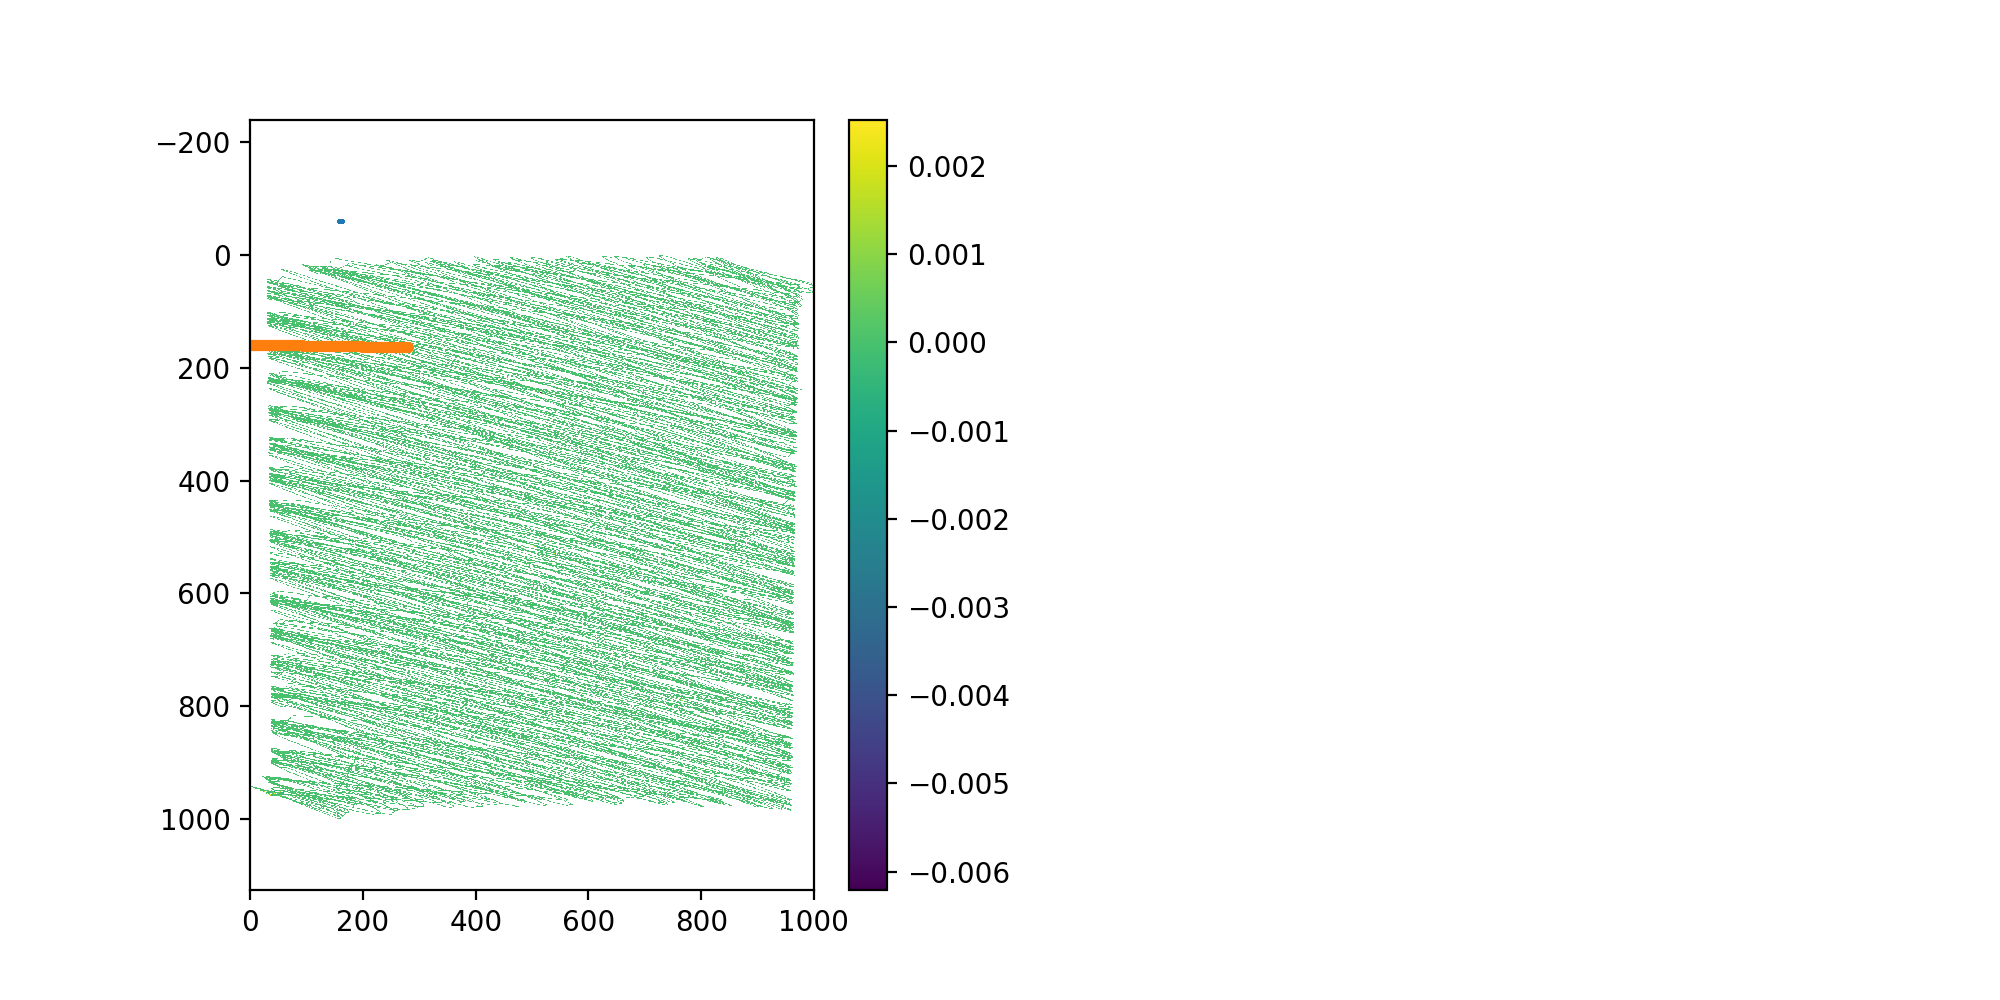

In [31]:
#%matplotlib notebook
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(mag_map.statistic.T,aspect='auto')
plt.axis('equal')
plt.colorbar()

In [32]:
import numpy as np 
import matplotlib.pyplot as plt

H = np.array([[1, 2, 3, 4],
          [5, 6, 7, 8],
          [9, 10, 11, 12],
          [13, 14, 15, 16]])

#plt.imshow(H)
#mess around with something like this to bin my stuff

In [33]:
ra_100.max(), ra_100.min(), dec_100.max(),dec_100.min()

(10.886784609407439,
 10.576154194772487,
 -59.12058080546341,
 -60.166597981003704)

In [34]:
def ra_to_deg(ra):
    ra = ra*15
    return ra

In [35]:
ra_100_deg = ra_to_deg(ra_100)

In [36]:
plt.plot(ra_100_deg, dec_100)

In [127]:
# for posterity, the original processing function
def arb_map_gen(ra, dec, bolo_data, pixel_size):
    #note that the bolo data ra and dec data passed must all be the same length
    # process the RA and DEC data into degrees first and interpolate.
    #pixel size is in degrees so pass ra and dec in degrees
    n_ra = np.int(np.ceil((ra.max()-ra.min())/pixel_size))
    n_dec = np.int(np.ceil((dec.max()-dec.min())/pixel_size))
    ra_bins, dec_bins = [], []
    ijbol_list = []
    size = [n_ra, n_dec]
    print n_ra
    print n_dec
    for i in range(0, n_ra):
        ra_bins.append(ra.min()+i*pixel_size)
    for j in range(0, n_dec):
        dec_bins.append(dec.min()+j*pixel_size)
    for n in range(0, len(bolo_data)):
        ra_test = np.abs(ra_bins-ra[n])
        dec_test = np.abs(dec_bins-dec[n])
        i_ind = np.where(ra_test == np.min(ra_test))
        j_ind = np.where(dec_test == np.min(dec_test))
        ijbol_list.append([bolo_data[n], i_ind[0][0], j_ind[0][0]])
    return ijbol_list, size

In [130]:
%%time
a, s = arb_map_gen(ra_100_deg,dec_100, bolo[bolo_start+1:bolo_start+bolo_range-1], .0167)

280
63
CPU times: user 26.1 s, sys: 299 ms, total: 26.4 s
Wall time: 30.2 s


In [131]:
def map_from_arb(arb_gen_out, size):
    print arb_gen_out[0][0],arb_gen_out[0][1],arb_gen_out[0][2]
    print size

In [132]:
map_from_arb(a,s)

1.4708120197447823 55 55
[280, 63]


In [124]:
print 'ra', ra_100_deg[1]
print 'ra max', ra_100_deg.max(), 'ra_min', ra_100_deg.min()
print 'dec', dec_100[1]
print 'dec max', dec_100.max(), 'dec min', dec_100.min()

ra 159.56014272664112
ra max 163.30176914111158 ra_min 158.6423129215873
dec -59.24837140179954
dec max -59.12058080546341 dec min -60.166597981003704


In [187]:
def arb_map_gen_gabs(ra, dec, bolo_data, pixel_size):
    #pixel size is in degrees so pass ra and dec in degrees
    #pixel size is in degrees so pass ra and dec in degrees
    n_ra = np.int(np.ceil((ra.max()-ra.min())/pixel_size))+1
    n_dec = np.int(np.ceil((dec.max()-dec.min())/pixel_size))+1

    ra_bins = np.amin(ra)-pixel_size/2.+np.arange(n_ra+1)*pixel_size
    dec_bins = np.amin(dec)-pixel_size/2.+np.arange(n_dec+1)*pixel_size

    i_ind = np.digitize(ra,ra_bins)
    j_ind = np.digitize(dec, dec_bins)

    bolo_array = np.zeros((len(bolo_data),3))

    bolo_array[:,0] = bolo_data
    bolo_array[:,1] = i_ind
    bolo_array[:,2] = j_ind
    size = [n_ra, n_dec]
    return bolo_array, size

In [186]:
%%time
a_gabs = arb_map_gen_gabs(ra_100_deg,dec_100, bolo[bolo_start+1:bolo_start+bolo_range-1], .0167)

CPU times: user 29.1 ms, sys: 8.8 ms, total: 38 ms
Wall time: 36.6 ms


In [166]:
a_gabs[1]

array([ 1.47081685, 55.        , 55.        ])

In [167]:
len(a_gabs)

590398

In [168]:
b = a-a_gabs
iS = []
jS = []

In [169]:
for i in range(len(b)):
    iS.append(b[i][1])
    jS.append(b[i][2])

In [173]:
np.max(iS)

0.0

In [179]:
print iS[18153:18187], jS[18153:18187]

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0] [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


In [184]:
print a[18153], a_gabs[18153]

[1.460930545560104, 268, 48] [  1.46093055 269.          49.        ]
